# Overview of Scenario

The following demonstrations will show us detecting fraudulent labels by using a copyrighted image as a base.



//the target beer label. Afterwards, the notebook will display images of labels that the deep learning one shot //system selects as being fraudulent. Then the notebook will display images of labels that the system selects as //being non-fradulent.

First: We need to configure ....

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import os

testdata_dir = os.environ['MLDIR'] + "TestData/"
np.random.seed(1000)
img_shape = (224, 224, 3)
l2_reg = 0
# Create the Deep Learning Model to detect fraudulent labels
# Layer 1
alexnet = Sequential()
alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))
# Layer 2 
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))




x = np.zeros((2, 224, 224, 3))

# Load the validation image, or target image
subject01 = Image.open(testdata_dir + 'label_fraud/beer_label_fraud/Bud_Label.png')

# Load in input image
subject02 = Image.open(testdata_dir + 'label_fraud/beer_label_fraud/images/Bud_Light_Label.png')

# Normalize the input images
subject01 = subject01.convert('RGB')
subject02 = subject02.convert('RGB')
subj01 = subject01.resize((224, 224))
subj02 = subject02.resize((224, 224))
subj01_a = np.array(subj01)
subj02_a = np.array(subj02)


#Here's where we do some voodoo
x[0] = subj01_a
x[1] = subj02_a
x_out_1 = alexnet.predict(x[0:2])
x_out_1_r = np.ravel(x_out_1[0])
x_out_2_r = np.ravel(x_out_1[1])

be_l, hist_l = np.histogram(x_out_1_r, bins=100000, range=[0.0, 250.0], density = True)
cor01 = np.dot(be_l[:], be_l[:])

# Calculate the
be_h, hist_h = np.histogram(x_out_2_r, bins=100000, range=[0.0, 250.0], density = True)
cor02 = np.dot(be_h[:], be_l[:])

#print('cor01 = ' + str(cor01) + ' cor02 = ' + str(cor02))




# Target Image

Below is the target image. This image represents the company's legit image that we will be using to determine fraudulent images.  This is a registered trademark and all other images will be compared against it:

![alt text](./TestData/label_fraud/beer_label_fraud/Bud_LabelSmall.png "Logo Title Text 1")

# Dataset construction

Here we prepare the dataset for our validation run

## Detected fradulent images:

From the dataset we constructed - We'll now detect which labels are fraudulent...

10


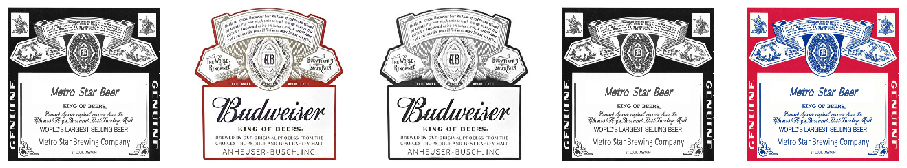

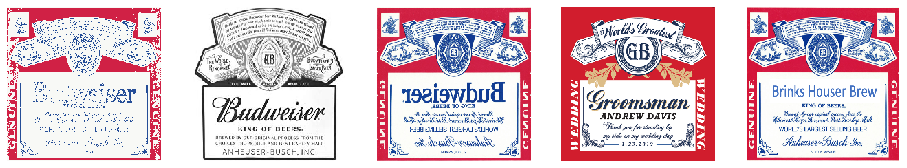

In [18]:
from os import walk
import cv2

mypath = testdata_dir + '/label_fraud/beer_label_fraud/images/'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(filenames)
    break
    
#print(f[0])
similar_diff = 0.03*cor01
img_list = []
for fn in f[0]:
    
    # Load test beer label image
    subject02 = Image.open(mypath + fn)
    
    # Normalize beer label image
    subject02 = subject02.convert('RGB')
    subj02 = subject02.resize((224, 224))
    subj02_a = np.array(subj02)
    save_0 = subj02_a[:,:,0]
    save_1 = subj02_a[:,:,1]
    x[0] = subj02_a

    # Process normalized beer label through model to generate feature vectors
    x_out_2 = alexnet.predict(x[0:1])
    x_out_2_r = np.ravel(x_out_2[0])
    
    # Generate histogram, and correlation product to determine if the label is fraudulent
    be_h, hist_h = np.histogram(x_out_2_r, bins=100000, range=[0.0, 250.0], density = True)
    cor02 = np.dot(be_h[:], be_l[:])
    
    # Threshold the correlation product to determine fraudulence
    diff = np.abs(cor02-cor01)
    if(diff < similar_diff):
  #      print(mypath + fn)
        img_list.append(subj02_a)

# Plot the fraudulent beer labels
(a1, a2) = plt.subplots(1,5, figsize=(16, 16))
a2[0].imshow(img_list[0])
a2[0].axis('off')

a2[1].imshow(img_list[1])
a2[1].axis('off')

a2[2].imshow(img_list[2])
a2[2].axis('off')

a2[3].imshow(img_list[3])
a2[3].axis('off')

a2[4].imshow(img_list[4])
a2[4].axis('off')
plt.show()


(a1, a2) = plt.subplots(1,5, figsize=(16, 16))
a2[0].imshow(img_list[5])
a2[0].axis('off')

a2[1].imshow(img_list[6])
a2[1].axis('off')

a2[2].imshow(img_list[7])
a2[2].axis('off')

a2[3].imshow(img_list[8])
a2[3].axis('off')

a2[4].imshow(img_list[9])
a2[4].axis('off')
plt.show()



# Show/Dected Non- Fraudulent Lables

Here we're showing all the labels that weren't put together by theives!

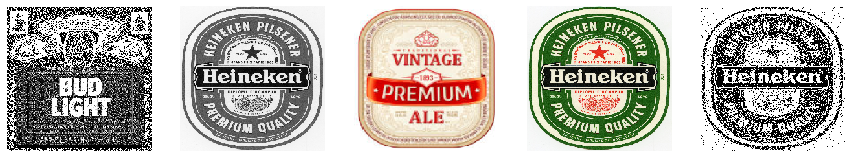

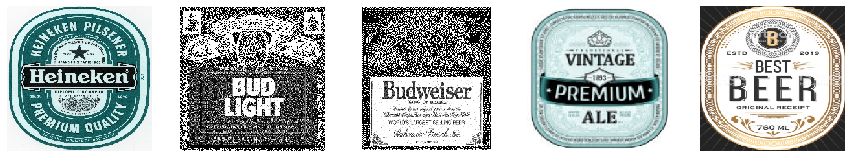

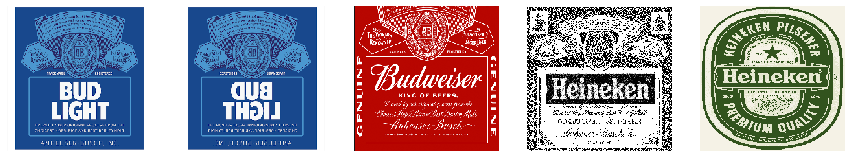

In [21]:
from os import walk
import cv2

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(filenames)
    break
    
#print(f[0])
similar_diff = 0.03*cor01
img_list = []
for fn in f[0]:
    
    # Load input beer label image
    subject02 = Image.open(mypath + fn)
    # Normalize input beer labe image
    subject02 = subject02.convert('RGB')
    subj02 = subject02.resize((224, 224))
    subj02_a = np.array(subj02)  
    x[0] = subj02_a
    
    # Process normalized beer label through model to generate feature vectors
    x_out_2 = alexnet.predict(x[0:1])
    x_out_2_r = np.ravel(x_out_2[0])
    # Generate histogram, and correlation product to determine if the label is fraudulent
    be_h, hist_h = np.histogram(x_out_2_r, bins=100000, range=[0.0, 250.0], density = True)
    cor02 = np.dot(be_h[:], be_l[:])
    # Threshold the correlation product to determine fraudulence
    diff = np.abs(cor02-cor01)
    if(diff > similar_diff):
        img_list.append(subj02_a)

# Display non-fraudulent beer labels
(a1, a2) = plt.subplots(1,5, figsize=(15,15))
a2[0].imshow(img_list[0])
a2[0].axis('off')

a2[1].imshow(img_list[1])
a2[1].axis('off')

a2[2].imshow(img_list[2])
a2[2].axis('off')

a2[3].imshow(img_list[3])
a2[3].axis('off')

a2[4].imshow(img_list[4])
a2[4].axis('off')
plt.show()

(a1, a2) = plt.subplots(1,5, figsize=(15,15))
a2[0].imshow(img_list[5])
a2[0].axis('off')

a2[1].imshow(img_list[6])
a2[1].axis('off')

a2[2].imshow(img_list[7])
a2[2].axis('off')

a2[3].imshow(img_list[8])
a2[3].axis('off')

a2[4].imshow(img_list[9])
a2[4].axis('off')
plt.show()

(a1, a2) = plt.subplots(1,5, figsize=(15,15))
a2[0].imshow(img_list[10])
a2[0].axis('off')

a2[1].imshow(img_list[11])
a2[1].axis('off')

a2[2].imshow(img_list[12])
a2[2].axis('off')

a2[3].imshow(img_list[13])
a2[3].axis('off')

a2[4].imshow(img_list[14])
a2[4].axis('off')
plt.show()





# Complete Data Test 

Below are all the images in the test dataset

